# Storage Report - By Schema and Table
Query a database to summarize storage usage in the database using a standard Administrative Table Function command. This example uses the [ADMINTABINFO administrative view](https://www.ibm.com/support/knowledgecenter/en/SSEPGG_11.1.0/com.ibm.db2.luw.sql.rtn.doc/doc/r0052897.html).

## Db2 Extensions
This tutorial relies on a Jupyter notebook extensions, commonly refer to as a "magic" commands. The beginning of all of the notebooks begin with the following command which will load the extension and allow the remainder of the notebook to use the %sql magic command.
<pre>
&#37;run db2.ipynb
</pre>
The cell below will load the Db2 extension. Note that it will take a few seconds for the extension to load, so you should generally wait until the "Db2 Extensions Loaded" message is displayed in your notebook. You can find out more about the Db2 Extensions at https://github.com/DB2-Samples/db2jupyter

In [2]:
%run db2.ipynb

Pixiedust database opened successfully


DB2 Extensions Loaded.


In [3]:
# load pandas for dataframe support and numpy for statistical manipulation and matplot for graphing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Connections to Db2

Before any SQL commands can be issued, a connection needs to be made to the Db2 database that you will be using. The connection can be done manually (through the use of the CONNECT command), or automatically when the first %sql command is issued.

The Db2 magic command tracks whether or not a connection has occured in the past and saves this information between notebooks and sessions. When you start up a notebook and issue a command, the program will reconnect to the database using your credentials from the last session. In the event that you have not connected before, the system will prompt you for all the information it needs to connect. This information includes:

- Database name (SAMPLE) 
- Hostname - localhost (enter an IP address if you need to connect to a remote server) 
- PORT - 50000 (this is the default but it could be different) 
- Userid - DB2INST1 
- Password - No password is provided so you have to enter a value 
- Maximum Rows - 10 lines of output are displayed when a result set is returned 

There will be default values presented in the panels that you can accept, or enter your own values. All of the information will be stored in the directory that the notebooks are stored on. Once you have entered the information, the system will attempt to connect to the database for you and then you can run all of the SQL scripts. More details on the CONNECT syntax will be found in a section below.

The next statement will force a CONNECT to occur with the default values. If you have not connected before, it will prompt you for the information.

In [ ]:
%sql connect reset

In [6]:
# create a persistent connection to the DSM Historical Repository Database
%sql connect to BLUDB user bluadmin using ? host 9.30.254.152 port 50000

Password [password]: ········
Connection successful.


## Query Key Performance Indicators

The [ADMINTABINFO administrative view](https://www.ibm.com/support/knowledgecenter/en/SSEPGG_11.1.0/com.ibm.db2.luw.sql.rtn.doc/doc/r0052897.html)
returns size and state information for tables, materialized query tables (MQT) and hierarchy tables only. These table types are reported as T for table, S for materialized query tables and H for hierarchy tables in the SYSCAT.TABLES catalog view. The information is returned at both the data partition level and the database partition level for a table.

In a Db2® pureScale® environment, values reported for a table are identical on all members since all members operate on a single physical partition of data. This is unlike in a partitioned database environment, where each member operates on a different physical partition of data, and reports different values. Because the values on all members are always the same, the ADMINTABINFO view and the ADMIN_GET_TAB_INFO table functions return only a single row for each table when run on a Db2 pureScale instance.

The schema is SYSIBMADM.

Refer to the Information returned by [ADMINTABINFO administrative view](https://www.ibm.com/support/knowledgecenter/en/SSEPGG_11.1.0/com.ibm.db2.luw.sql.rtn.doc/doc/r0052897.html)
 and ADMIN_GET_TAB_INFO table for a complete list of information that can be returned.
 
The Query below adds up the size of all the object types reported by the Administrative View to get the total storage used by each table and its supporting objects

In [7]:
%%sql 
SELECT TABSCHEMA, TABNAME, TABTYPE, (
  SUM(DATA_OBJECT_P_SIZE) +
   SUM(INDEX_OBJECT_P_SIZE) +
   SUM(LONG_OBJECT_P_SIZE) +
   SUM(LOB_OBJECT_P_SIZE) +
   SUM(XML_OBJECT_P_SIZE) +
   SUM(COL_OBJECT_P_SIZE)) AS SIZEMB
  FROM SYSIBMADM.ADMINTABINFO
  GROUP BY TABSCHEMA, TABNAME, TABTYPE
  ORDER BY SIZEMB DESC;

,TABSCHEMA,TABNAME,TABTYPE,SIZEMB
0,DB2INST1,BIG2G-4,T,560768
1,DB2INST1,BIG2G,T,539520
2,DB2INST1,BIG2G-3,T,495872
3,DB2INST1,BIG2G-2,T,483200
4,IBMOTS,SQL_DIM,T,478720
...,...,...,...,...
890,QUERYTUNER,OQWT_TUNING_PREF_PROPERTIES,T,256
891,QUERYTUNER,OQWT_VERSION,T,256
892,SYSTOOLS,IDAX_MODELS,T,256
893,SYSTOOLS,QT_WAPC_SESSIONS,T,256


## Analyze the Storage Data

To access the powerful analytic capabilities in a Python notebook, you need to use DataFrames. By passing the results of the Magic command to a variable you immediately create a Data Frame.

In [8]:
# run a select and pass the results to a Data Frame
tablesize = %sql \
SELECT TABSCHEMA, TABNAME, TABTYPE, \
(SUM(DATA_OBJECT_P_SIZE) + \
 SUM(INDEX_OBJECT_P_SIZE) + \
 SUM(LONG_OBJECT_P_SIZE) + \
 SUM(LOB_OBJECT_P_SIZE) + \
 SUM(XML_OBJECT_P_SIZE) + \
 SUM(COL_OBJECT_P_SIZE)) AS SIZEMB \
FROM SYSIBMADM.ADMINTABINFO \
GROUP BY TABSCHEMA, TABNAME, TABTYPE 

In [9]:
# review the first few rows of the dataframe to make sure you are getting a valid result set
tablesize.head()

,TABSCHEMA,TABNAME,TABTYPE,SIZEMB
0,AA,T1,T,29824
1,AA,T13,T,19968
2,AA,T6,T,17664
3,AA,T7,T,17664
4,AB,T1,T,19968


### Sort by the table size to see the largest and smallest tables in the database. 

In [10]:
tablesize.sort_values('SIZEMB')

,TABSCHEMA,TABNAME,TABTYPE,SIZEMB
545,HEALTHMETRICS,DB2ZSYSPARMS,T,256
207,IBMOTS,MGCLIENT_MON_SETTING,T,256
208,IBMOTS,MGCLIENT_MON_SETTING_CLIENT_INFO_MASK,T,256
209,IBMOTS,MGCLIENT_MON_SETTING_DATASOURCE,T,256
210,IBMOTS,MGCLIENT_MON_TXN_DATA,T,256
...,...,...,...,...
656,IBMOTS,SQL_DIM,T,478720
50,DB2INST1,BIG2G-2,T,483200
51,DB2INST1,BIG2G-3,T,495872
490,DB2INST1,BIG2G,T,539520


In [11]:
# Note that running the sort operator against the dataframe does not change the original organization of the dataframe. 
tablesize.head()

,TABSCHEMA,TABNAME,TABTYPE,SIZEMB
0,AA,T1,T,29824
1,AA,T13,T,19968
2,AA,T6,T,17664
3,AA,T7,T,17664
4,AB,T1,T,19968


### Distribution of data
The describe function breaks down the statistical information retrieved

In [156]:
tablesize.describe()

,SIZEMB
count,895.000000
mean,9455.696089
std,43764.232280
min,256.000000
25%,512.000000
50%,640.000000
75%,5888.000000
max,560768.000000


### Pivot
Create a pivot of the data frame showing the size of each schema including the individual tables names. 

In [157]:
pd.options.display.max_rows = 20
pd.pivot_table(tablesize,index=["TABSCHEMA","TABNAME"])

SIZEMB
TABSCHEMA TABNAME                              
AA        T1                              29824
          T11                             19968
          T13                             19968
          T2                              19968
          T3                              22528
          T4                              29824
          T6                              17664
          T7                              17664
          T8                              17664
          T9                              17664
...                                         ...
SYSTOOLS  QT_WCC_STMT_RUNTIME_METRICS      1024
          QT_WCC_STMT_TEXT                 1024
          QT_WCC_TEMP_CAPTURE              1024
          QT_WCC_TEMP_EXPLAIN_HANDLE        512
          QT_WCC_WORKLOAD                   512
          QT_WCC_WORKLOAD_ADVISOR_INFO     1024
          QT_WCC_WORKLOAD_NAME              256
          QT_WCC_WORKLOAD_SOURCE            512
          QT_WCC_WORKLOAD_SOURCE_FILTER    1024
          QT_WCC_WORKLOAD_TASK             1024

[895 rows x 1 columns]

In [14]:
#To see the biggest two tables in each schema, you can use sort, groupby and head operators in sequence. Operations go left to right
tablesize.sort_values(by='SIZEMB', ascending=False).groupby("TABSCHEMA").head(2)

,TABSCHEMA,TABNAME,TABTYPE,SIZEMB
52,DB2INST1,BIG2G-4,T,560768
490,DB2INST1,BIG2G,T,539520
656,IBMOTS,SQL_DIM,T,478720
395,SYSIBM,SYSSECTION,T,396672
452,BLUADMIN,SPARK_TEST_DATA,T,307840
11,BLUADMIN,HAO_LOAD_COMPUTER2,T,99200
770,SYSIBM,SYN180516063110896534_TINY_TABLE_CD6,T,43264
260,IBM_RTMON_DATA,monGetMemoryPoolDpf,T,42496
33,BLUTESTADMIN,TINY_TABLE_CD6,T,31744
0,AA,T1,T,29824


### Size by Schema
Aggregate the values by group to resolve the size by schema

In [159]:
bySchema = tablesize.groupby('TABSCHEMA').aggregate(np.sum)
bySchema

,SIZEMB
TABSCHEMA,
AA,212736
AB,39936
BLUADMIN,867456
BLUTESTADMIN,1125120
DB2GSE,21504
DB2INST1,2409472
DB2OE,10368
DB2OSC,28672
DSJOBMGR,2048


### Graph Schema Size
Draw a graph of the size of each schema in the database. Adding the sort clause allows you to order the schemas from smallest to largest.

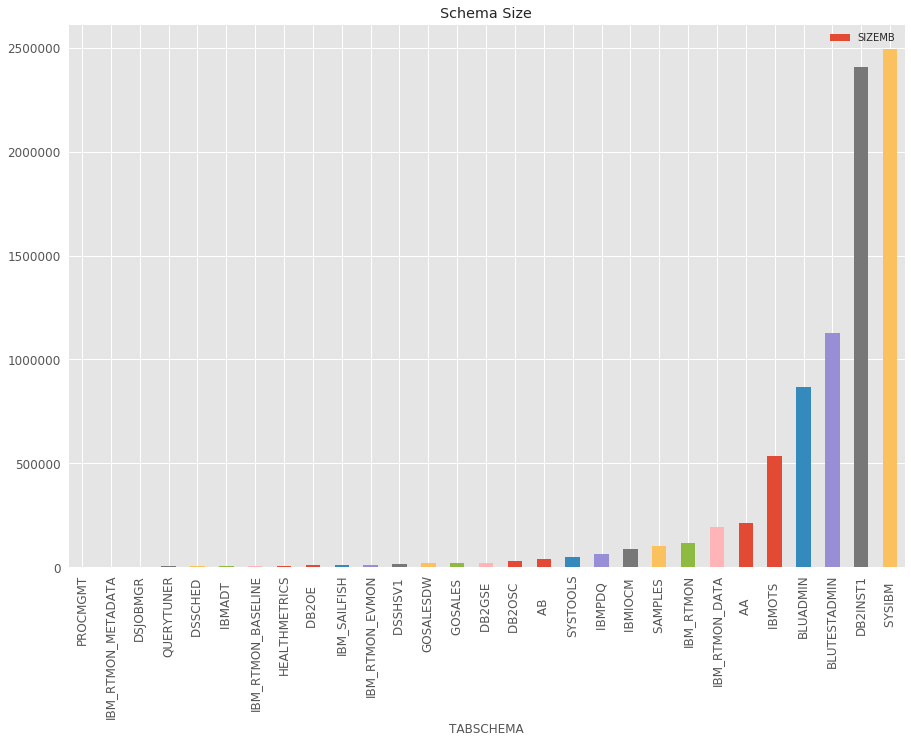

In [160]:
bySchema.sort_values('SIZEMB').plot(y='SIZEMB',kind='bar', title ="Schema Size", figsize=(15, 10), legend=True, fontsize=12)
plt.show()